In [1]:
# add local directory to import path
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#### --- Standard imports ------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost

from IPython.display import HTML

from importlib import reload

# local import
import nflplot
import nflutil
import nfl_bdb22

# ======== NOTEBOOK SETTINGS ====================
flag_run_modelsearch = False  # True = run CV search, False = use fixed parameters

In [3]:
game_df = pd.read_csv('csv/games.csv')
play_df = pd.read_csv('csv/plays.csv')
pff_df = pd.read_csv('csv/PFFScoutingData.csv')
player_df = pd.read_csv('csv/players.csv')

# Get plays with a fair catch

In [4]:
n_defenders = 5

# years = [2018, 2019, 2020]
years = [2020]
dfs = []
for year in years:
    track_df = nflutil.transform_tracking_data(pd.read_csv(f'csv/tracking{year}.csv'))

    temp_feature_df = (
        nfl_bdb22.prep_get_modeling_frames(track_df, 
                                    play_df=play_df, 
                                    pff_df=pff_df, 
                                    play_end_event_name='fair_catch'
                                    )
        .pipe(nfl_bdb22.model_create_features, play_df=play_df, game_df=game_df, n_defenders=n_defenders, catch_type='fair_catch')
        .query('timeToCatch==1.5')
    )
    dfs.append(temp_feature_df)

feature_df = pd.concat(dfs)

feature_df

,gameId,playId,frameId,timeToCatch,willReach,reachWithin5,reachWithin10,reachWithin20,reachWithin30,"(dist, 1)",...,"(upGutLeverage, 5)","(willReachFactor, 1)","(willReachFactor, 2)","(willReachFactor, 3)","(willReachFactor, 4)","(willReachFactor, 5)",s_abs,s_dwnfld,s_lateral,distFromSideline
26,2021010300,1232,65,1.5,2,2,3,8,10,7.403736,...,2.02,-0.398803,-0.305350,0.800059,0.961625,1.195492,3.04,1.721000,2.505945,14.56
75,2021010301,510,64,1.5,1,1,1,7,8,13.946541,...,12.14,-0.061787,0.722898,0.726669,1.155555,1.170140,4.26,-0.947421,4.153311,11.79
123,2021010301,2508,63,1.5,2,4,6,10,10,6.382633,...,0.84,-0.466781,-0.259890,0.214069,0.443612,0.522326,4.18,4.142700,0.557170,17.96
170,2021010301,3422,64,1.5,1,1,2,2,6,13.691461,...,12.81,-0.079875,0.596836,1.775520,1.467536,1.950750,2.94,-2.564887,1.436994,14.39
218,2021010301,3649,65,1.5,1,1,2,4,8,13.163879,...,7.01,-0.000465,0.505095,1.038606,1.190087,1.542297,3.67,1.217219,3.462265,8.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23196,2020091312,3986,66,1.5,1,1,2,6,10,8.322656,...,3.09,-0.442928,0.444928,0.775201,1.766657,1.528770,5.32,-5.197685,1.134229,23.55
23240,2020091312,4144,61,1.5,0,2,2,6,7,14.293317,...,5.85,0.031264,0.271545,0.938630,1.185536,1.594608,3.08,-1.018492,2.906729,15.45
23284,2020091400,2236,60,1.5,1,2,2,5,9,12.783435,...,8.32,-0.041362,0.225574,1.110256,1.142809,1.200933,2.37,-1.545473,1.796778,23.17
23327,2020091401,247,59,1.5,0,1,2,3,8,17.832566,...,7.29,0.239664,0.506854,1.229339,1.766006,2.114446,1.86,1.142314,1.467896,20.82


Predict punt yards on fair catch plays at simulated "fair catch" signal frame

In [5]:
with open('yd_predict_model.pickle', 'rb') as file:
    model = pickle.load(file)

In [6]:
yardage_pred = model.predict(X=feature_df.drop(columns=['gameId','playId','frameId']))
# attach gameId, playId, and frameId back to prediction
predict_df = feature_df[['gameId','playId','frameId']].assign(pry_pred=yardage_pred).reset_index(drop=True)

In [7]:
pd.Series(yardage_pred).describe()

count    504.000000
mean       5.060802
std        1.781056
min        1.178722
25%        3.859450
50%        4.937349
75%        6.152803
max       11.388199
dtype: float64

In [8]:
predict_df

,gameId,playId,frameId,pry_pred
0,2021010300,1232,65,3.476590
1,2021010301,510,64,5.935471
2,2021010301,2508,63,1.853356
3,2021010301,3422,64,7.370547
4,2021010301,3649,65,5.145041
...,...,...,...,...
499,2020091312,3986,66,7.518534
500,2020091312,4144,61,5.222226
501,2020091400,2236,60,5.217594
502,2020091401,247,59,5.891099


# Attach predicted yardage to players and teams

In [9]:
puntreturn_df = (
    predict_df
    # get returner nflId
    .merge(play_df[['gameId','playId','possessionTeam','returnerId']],
           how='inner',
           on=['gameId', 'playId'])
    .assign(returnerId=lambda df_: pd.to_numeric(df_.returnerId))
    # get team information
    .merge(game_df[['gameId','homeTeamAbbr','visitorTeamAbbr','season','week']],
           how='inner',
           on=['gameId'])
    # set the returning team - the opposite of the possesion team (defined as the one kicking/punting the ball)
    .assign(receivingTeam=lambda df_: np.where(df_.possessionTeam==df_.homeTeamAbbr, df_.visitorTeamAbbr, df_.homeTeamAbbr))
    .drop(columns=['homeTeamAbbr', 'visitorTeamAbbr'])
    # add returner name
    .merge(player_df[['nflId', 'displayName']],
           how='left',
           left_on='returnerId',
           right_on='nflId')
    .drop(columns='returnerId')
)

In [10]:
puntreturn_df

,gameId,playId,frameId,pry_pred,possessionTeam,season,week,receivingTeam,nflId,displayName
0,2021010300,1232,65,3.476590,MIA,2020,17,BUF,44985,Isaiah McKenzie
1,2021010301,510,64,5.935471,CAR,2020,17,NO,43948,Tommylee Lewis
2,2021010301,2508,63,1.853356,NO,2020,17,CAR,43406,Pharoh Cooper
3,2021010301,3422,64,7.370547,NO,2020,17,CAR,43406,Pharoh Cooper
4,2021010301,3649,65,5.145041,NO,2020,17,CAR,43406,Pharoh Cooper
...,...,...,...,...,...,...,...,...,...,...
499,2020091312,3986,66,7.518534,DAL,2020,1,LA,44881,Cooper Kupp
500,2020091312,4144,61,5.222226,LA,2020,1,DAL,46277,Cedrick Wilson
501,2020091400,2236,60,5.217594,PIT,2020,1,NYG,44837,Jabrill Peppers
502,2020091401,247,59,5.891099,TEN,2020,1,DEN,42051,Diontae Spencer


## Analysis by player

In [11]:
min_faircatch_threshold = 8

In [12]:
player_analysis_df = (
    puntreturn_df
    .groupby('displayName')
     .filter(lambda x: x.displayName.count() >= min_faircatch_threshold)
)

<Axes: xlabel='count', ylabel='Count'>

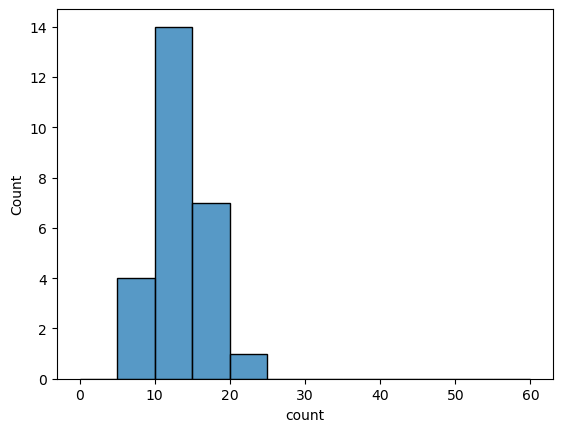

In [13]:
sns.histplot(player_analysis_df['displayName'].value_counts(), bins=range(0,61,5))

<Axes: xlabel='displayName', ylabel='pry_pred'>

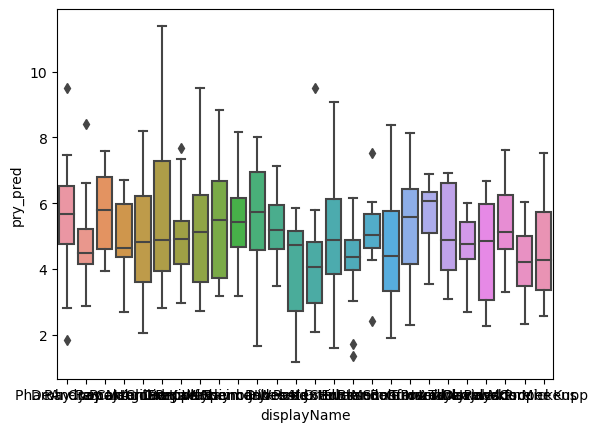

In [14]:
sns.boxplot(player_analysis_df, x='displayName', y='pry_pred')

**Highest and lowest predicted yardage plays**

In [15]:
player_analysis_df.sort_values('pry_pred', ascending=False)

,gameId,playId,frameId,pry_pred,possessionTeam,season,week,receivingTeam,nflId,displayName
174,2020112902,3007,62,11.388199,CIN,2020,12,NYG,44837,Jabrill Peppers
352,2020101812,1752,68,9.512361,NE,2020,6,DEN,42051,Diontae Spencer
154,2020120611,4027,63,9.498339,NE,2020,13,LAC,52628,K.J. Hill
365,2020101100,1789,55,9.488437,ATL,2020,5,CAR,43406,Pharoh Cooper
97,2020122100,1689,58,9.088969,PIT,2020,15,CIN,43663,Alex Erickson
...,...,...,...,...,...,...,...,...,...,...
120,2020121312,219,60,1.717976,SF,2020,14,WAS,48051,Steven Sims
231,2020112300,1802,64,1.663075,TB,2020,11,LA,48784,Nsimba Webster
388,2020100402,2475,74,1.614278,JAX,2020,4,CIN,43663,Alex Erickson
62,2020122710,2965,62,1.357717,CAR,2020,16,WAS,48051,Steven Sims


**Players with the highest and lowest averages**

In [16]:
player_analysis_df.groupby(['displayName','nflId'])['pry_pred'].agg(['count','mean','std']).sort_values('mean', ascending=True).reset_index().rename(columns={'mean':'mean_faircatchlost'})

,displayName,nflId,count,mean_faircatchlost,std
0,Jakeem Grant,43475,8,4.068155,1.656745
1,Jaydon Mickens,44029,12,4.177959,1.249628
2,Steven Sims,48051,17,4.222257,1.268726
3,K.J. Hill,52628,8,4.460328,2.343834
4,Cooper Kupp,44881,10,4.593028,1.593642
5,Brandon Powell,46830,19,4.618690,1.946817
6,Andre Roberts,35527,11,4.688098,1.030912
7,Braxton Berrios,46279,22,4.782713,1.758751
8,David Moore,45039,13,4.803611,1.544709
9,Alex Erickson,43663,19,4.830363,1.871799


Plot average "given up yardage on fair catches" versus average on actual punt returns to see if there is any correlation

In [17]:
# punt plays with return yardage
play_filter = (play_df.specialTeamsPlayType=='Punt') & (play_df.specialTeamsResult=='Return') & (~play_df.kickReturnYardage.isna()) & (~play_df.returnerId.astype(str).str.contains(';') & (play_df.gameId.astype(str).str[:4].astype(int).isin(years)))

player_means = (
    player_analysis_df.groupby(['displayName','nflId'])['pry_pred'].agg(['count','mean']).sort_values('mean', ascending=False).reset_index()
    .merge(
        (
            play_df.loc[play_filter, ['returnerId','kickReturnYardage']]
            .assign(returnerId=lambda df_: pd.to_numeric(df_.returnerId))
            .rename(columns={'returnerId': 'nflId'})
            .groupby('nflId')['kickReturnYardage'].aggregate(['count','mean'])
        ),
        how='left',
        on='nflId'
    )
    .rename(columns={'count_x': 'fairCatches', 'mean_x': 'mean_faircatchlost', 'count_y': 'returns', 'mean_y': 'yardsPerReturn'})
)

player_means

,displayName,nflId,fairCatches,mean_faircatchlost,returns,yardsPerReturn
0,Ray-Ray McCloud,46256,18,5.803200,26,10.769231
1,Jabrill Peppers,44837,14,5.686742,12,10.666667
2,Trent Taylor,44990,11,5.637189,9,12.444444
3,Pharoh Cooper,43406,18,5.574726,17,5.294118
4,Nsimba Webster,48784,15,5.515874,23,7.652174
5,Nyheim Hines,46173,13,5.429306,25,10.000000
6,Kalif Raymond,43584,11,5.358586,23,9.043478
7,Mecole Hardman,47839,12,5.331731,24,7.333333
8,Diontae Spencer,42051,11,5.255612,12,17.916667
9,James Proche,52609,13,5.252093,23,8.608696


<Axes: xlabel='yardsPerReturn', ylabel='mean_faircatchlost'>

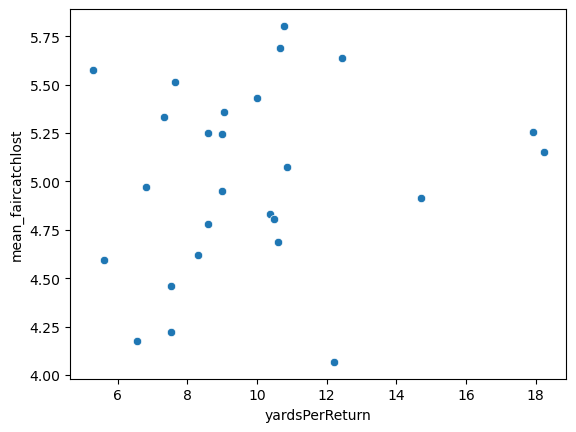

In [18]:
sns.scatterplot(player_means, x='yardsPerReturn', y='mean_faircatchlost')

## Analysis by team

Predicted yards

In [19]:
puntreturn_df.groupby('receivingTeam')['pry_pred'].agg(['count','mean']).sort_values('mean', ascending=True).reset_index().rename(columns={'mean':'mean_faircatchlost', 'count':'fair_catches'})

,receivingTeam,fair_catches,mean_faircatchlost
0,MIA,9,4.068596
1,HOU,11,4.172200
2,LAC,12,4.357475
3,JAX,11,4.361746
4,WAS,24,4.506223
5,ATL,20,4.515094
6,BUF,12,4.587140
7,ARI,12,4.657959
8,TB,14,4.664760
9,CLE,11,4.705075


Return yardage

In [20]:
# punt plays with return yardage
play_filter = (play_df.specialTeamsPlayType=='Punt') & (play_df.specialTeamsResult=='Return') & (~play_df.kickReturnYardage.isna()) & (play_df.gameId.astype(str).str[:4].astype(int).isin(years))

prbyteam_actual_df = (
    play_df.loc[play_filter, ['gameId','playId','possessionTeam','kickReturnYardage']]
    # get team information
    .merge(game_df[['gameId','homeTeamAbbr','visitorTeamAbbr','season','week']],
           how='inner',
           on=['gameId'])
    # set the returning team - the opposite of the possesion team (defined as the one kicking/punting the ball)
    .assign(receivingTeam=lambda df_: np.where(df_.possessionTeam==df_.homeTeamAbbr, df_.visitorTeamAbbr, df_.homeTeamAbbr))
    .drop(columns=['homeTeamAbbr', 'visitorTeamAbbr'])
    .groupby('receivingTeam')['kickReturnYardage']
    .aggregate(['count','mean'])
    .reset_index()
    .rename(columns={'mean':'mean_returnyardage', 'count':'returns'})
)
prbyteam_actual_df

,receivingTeam,returns,mean_returnyardage
0,ARI,22,6.045455
1,ATL,13,8.307692
2,BAL,25,9.360000
3,BUF,28,10.214286
4,CAR,17,5.294118
5,CHI,23,8.260870
6,CIN,19,10.368421
7,CLE,21,5.142857
8,DAL,21,5.619048
9,DEN,15,15.266667


## Plots

Merge predicted yardage and return yardage stats by team


In [21]:
team_colors = {abbr: c['main'] for abbr, c in nflutil.TEAM_COLORS.items()}
team_color_df = pd.DataFrame(zip(team_colors.keys(), team_colors.values()), columns=['teamAbbr','teamColor'])

prbyteam_df = (
    # get predicted yards by team
    puntreturn_df.groupby('receivingTeam')['pry_pred'].agg(['count','mean']).sort_values('mean', ascending=False).reset_index().rename(columns={'mean':'mean_faircatchlost'})
    # attach actual yards by team
    .merge(prbyteam_actual_df,
           how='inner',
           on='receivingTeam')
    # add colors for each team
    .merge(team_color_df,
           how='inner',
           left_on='receivingTeam',
           right_on='teamAbbr')
    .sort_values('mean_faircatchlost', ascending=True)
    )

prbyteam_df
# fig, ax = plt.subplots(figsize=(14,6))
# sns.barplot(prbyteam_df, x='teamAbbr',y='mean_faircatchlost', palette=prbyteam_df['teamColor'], ax=ax)

,receivingTeam,count,mean_faircatchlost,returns,mean_returnyardage,teamAbbr,teamColor
30,MIA,9,4.068596,28,11.821429,MIA,"[0.0, 0.5568627450980392, 0.592156862745098]"
29,HOU,11,4.172200,17,8.647059,HOU,"[0.011764705882352941, 0.12549019607843137, 0...."
28,LAC,12,4.357475,17,5.882353,LAC,"[0.0, 0.16470588235294117, 0.3686274509803922]"
27,JAX,11,4.361746,15,12.600000,JAX,"[0.0, 0.403921568627451, 0.47058823529411764]"
26,WAS,24,4.506223,22,6.545455,WAS,"[0.24705882352941178, 0.06274509803921569, 0.0..."
25,ATL,20,4.515094,13,8.307692,ATL,"[0.0, 0.0, 0.0]"
24,BUF,12,4.587140,28,10.214286,BUF,"[0.0, 0.2, 0.5529411764705883]"
23,ARI,12,4.657959,22,6.045455,ARI,"[0.6078431372549019, 0.13725490196078433, 0.24..."
22,TB,14,4.664760,28,6.035714,TB,"[0.8352941176470589, 0.0392156862745098, 0.039..."
21,CLE,11,4.705075,21,5.142857,CLE,"[1.0, 0.23529411764705882, 0.0]"


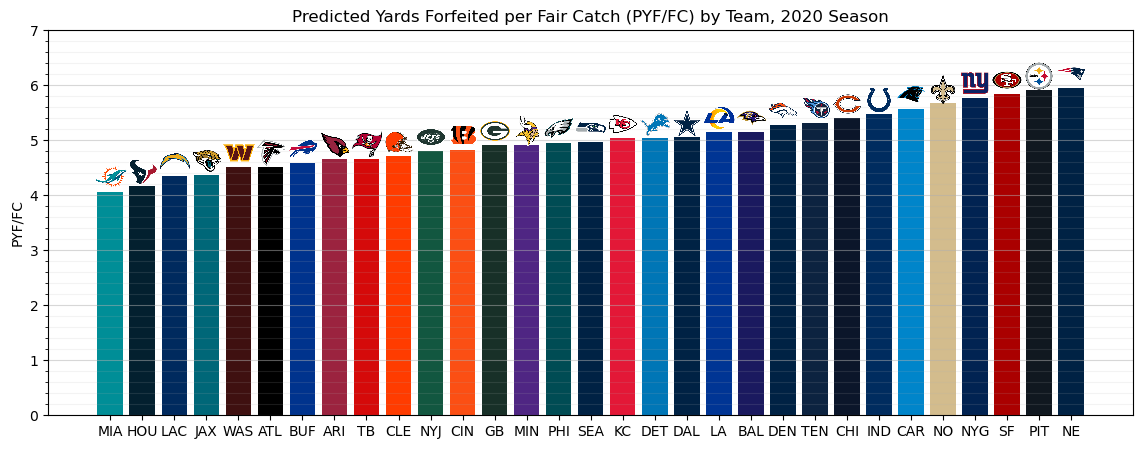

In [43]:
#create figure
f, ax = plt.subplots(figsize=(14,5))
# create bar plot
ax = nflplot.create_team_bar_plot(ax, prbyteam_df['teamAbbr'], prbyteam_df['mean_faircatchlost'])
# set labels and grid
ax.set_ylabel('PYF/FC')
ax.set_ylim([0, 7])
ax.set_title('Predicted Yards Forfeited per Fair Catch (PYF/FC) by Team, 2020 Season')
ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=False)
ax.grid(visible=True, which='major', axis='y', alpha=0.5)
ax.grid(visible=True, which='minor', axis='y', alpha=0.15)


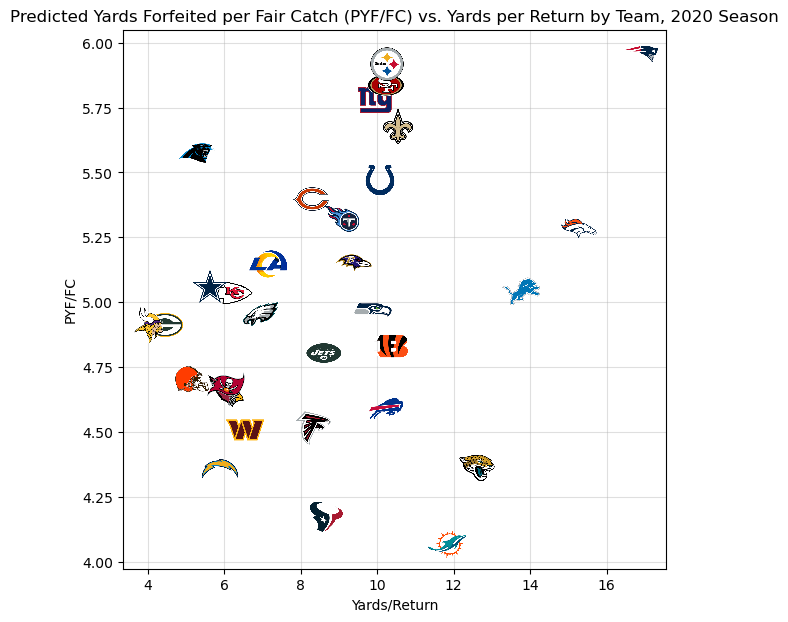

In [ ]:
# function to place image on plot
def offset_image_scatter(x, y, label, ax):
    img = plt.imread(f'./assets/logos/{label}.png')
    im = OffsetImage(img, zoom=0.10)
    im.image.axes = ax
    y_offset = 0
    ab = AnnotationBbox(im, (x, y), xybox=(0, y_offset), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    ax.add_artist(ab)

labels = prbyteam_df['teamAbbr']
colors = prbyteam_df['teamColor']
x = prbyteam_df['mean_returnyardage']
y = prbyteam_df['mean_faircatchlost']

#create figure
f, ax = plt.subplots(figsize=(7,7))
# create scatter plot
plt.scatter(x=x, y=y, alpha=0)
# add logos at each point
for (label, x_i, y_i) in zip(labels, x, y):
    # x = integer position (ranking), y = height of the bar (value)
    offset_image_scatter(x_i, y_i, label, ax=ax)
# set labels and grid
ax.set_xlabel('Yards/Return')
ax.set_ylabel('PYF/FC')
ax.set_title('Predicted Yards Forfeited per Fair Catch (PYF/FC) vs. Yards per Return by Team, 2020 Season')
plt.grid(visible=True, which='both', axis='both', alpha=0.4)

In [47]:
reload(nflplot)

<module 'nflplot' from 'c:\\Users\\pschl\\Documents\\data_science\\NFL\\kaggle_nfl_bdb_2022\\nflplot.py'>

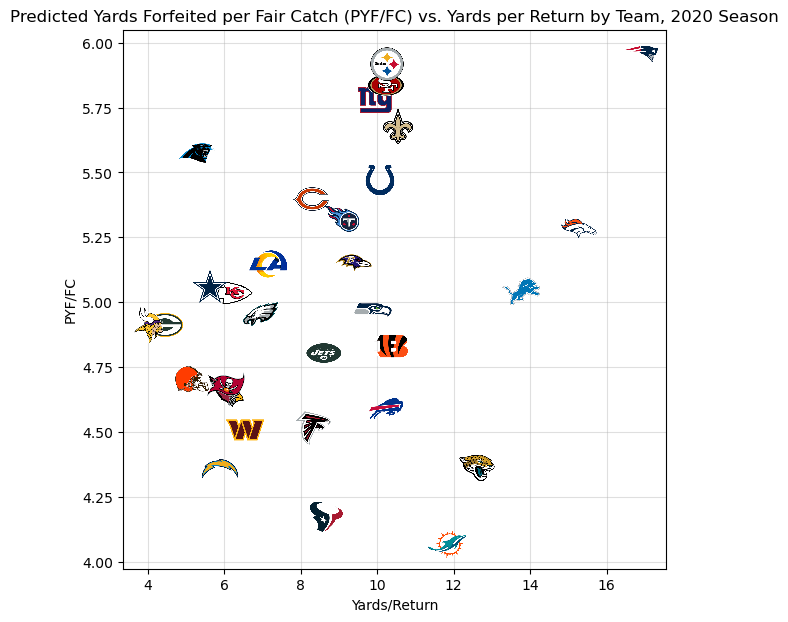

In [48]:
#create figure
f, ax = plt.subplots(figsize=(7,7))
# create scatter plot
ax = nflplot.create_team_scatter_plot(ax=ax, x=prbyteam_df['mean_returnyardage'], y=prbyteam_df['mean_faircatchlost'], team_labels=prbyteam_df['teamAbbr'])
# set labels and grid
ax.set_xlabel('Yards/Return')
ax.set_ylabel('PYF/FC')
ax.set_title('Predicted Yards Forfeited per Fair Catch (PYF/FC) vs. Yards per Return by Team, 2020 Season')
ax.grid(visible=True, which='major', axis='both', alpha=0.4)